<a href="https://colab.research.google.com/github/its-amrita-sarkar-01/Appliance-Energy-Prediction/blob/main/Appliance_Energy_Prediction_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data-driven prediction of energy use of appliances**

**The data set is at 10 min for about 4.5 months. The house temperature and humidity conditions were monitored with a ZigBee wireless sensor network. Each wireless node transmitted the temperature and humidity conditions around 3.3 min. Then, the wireless data was averaged for 10 minutes periods. The energy data was logged every 10 minutes with m-bus energy meters. Weather from the nearest airport weather station Chievres Airport, Belgium) was downloaded from a public data set from Reliable Prognosis (rp5.ru) and merged together with the experimental data sets using the date and time column. Two random variables have been included in the data set for testing the regression models and to filter out non-predictive attributes (parameters).**

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
import xgboost as xgb
from sklearn.svm import SVR
import time
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [39]:
file_path = '/content/drive/MyDrive/Colab Notebooks/AlmaBetter Capstone Project/data_application_energy.csv'
df = pd.read_csv(file_path)

In [ ]:
file_path = '/content/drive/MyDrive/capstone Alma Better/data_application_energy.csv'
df = pd.read_csv(file_path)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         19735 non-null  object 
 1   Appliances   19735 non-null  int64  
 2   lights       19735 non-null  int64  
 3   T1           19735 non-null  float64
 4   RH_1         19735 non-null  float64
 5   T2           19735 non-null  float64
 6   RH_2         19735 non-null  float64
 7   T3           19735 non-null  float64
 8   RH_3         19735 non-null  float64
 9   T4           19735 non-null  float64
 10  RH_4         19735 non-null  float64
 11  T5           19735 non-null  float64
 12  RH_5         19735 non-null  float64
 13  T6           19735 non-null  float64
 14  RH_6         19735 non-null  float64
 15  T7           19735 non-null  float64
 16  RH_7         19735 non-null  float64
 17  T8           19735 non-null  float64
 18  RH_8         19735 non-null  float64
 19  T9  

In [40]:
print('There are {} rows and {} columns'.format(df.shape[0], df.shape[1]) + 'in the Appliance Energy Prediction Dataset.')

There are 19735 rows and 29 columnsin the Appliance Energy Prediction Dataset.


**Number of rows : 19735 <br> No of features : 29 <br> Target Variable : Appliances**

All the columns are of numerical type and there are no null values in it.

In [41]:
#Overview of the dataset
df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [42]:
#Assigning the original names to the respective columns
df.rename(columns = {'T1' : 'temp_kitchen','RH_1' : 'humid_kitchen',
                     'T2' : 'temp_living','RH_2' : 'humid_living',
                     'T3' : 'temp_laundry', 'RH_3' : 'humid_laundry',
                     'T4' : 'temp_office', 'RH_4' : 'humid_office',
                     'T5' : 'temp_bath', 'RH_5' : 'humid_bath',
                     'T6' : 'temp_outside', 'RH_6' : 'humid_outside',
                     'T7' : 'temp_iron', 'RH_7' : 'humid_iron',
                     'T8' : 'temp_teen', 'RH_8' : 'humid_teen',
                     'T9' : 'temp_parents', 'RH_9' : 'humid_parents',
                     'T_out' : 'temp_station','RH_out' : 'humid_station'},inplace=True)

In [43]:
#rechecking dataset
df.head()

,date,Appliances,lights,temp_kitchen,humid_kitchen,temp_living,humid_living,temp_laundry,humid_laundry,temp_office,...,temp_parents,humid_parents,temp_station,Press_mm_hg,humid_station,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [44]:
#Statistical Summary
round(df.describe().T,2)

,count,mean,std,min,25%,50%,75%,max
Appliances,19735.0,97.69,102.52,10.00,50.00,60.00,100.00,1080.00
lights,19735.0,3.80,7.94,0.00,0.00,0.00,0.00,70.00
temp_kitchen,19735.0,21.69,1.61,16.79,20.76,21.60,22.60,26.26
humid_kitchen,19735.0,40.26,3.98,27.02,37.33,39.66,43.07,63.36
temp_living,19735.0,20.34,2.19,16.10,18.79,20.00,21.50,29.86
humid_living,19735.0,40.42,4.07,20.46,37.90,40.50,43.26,56.03
temp_laundry,19735.0,22.27,2.01,17.20,20.79,22.10,23.29,29.24
humid_laundry,19735.0,39.24,3.25,28.77,36.90,38.53,41.76,50.16
temp_office,19735.0,20.86,2.04,15.10,19.53,20.67,22.10,26.20
humid_office,19735.0,39.03,4.34,27.66,35.53,38.40,42.16,51.09


- Average temperature inside the building is 23 degrees for the recorded time.
- Highest temperature recorded inside is 29.86 degrees which is on the living room while the lowest being 24.5 degrees on the parents room.
- Highest recorded temperature outside is 28.29 degrees and the lowest being -6 degrees
- So this difference in temperature inside and outside are being maintained by using warming appliances.

- It is clearly evident from the given data that average humidity outside is higher in comparison to inside humidity.
- Average humidity in the station is quite higher than the other places.
- Average humidity inside the house is slightly higher in the bathroom.

In [45]:
other_cond = df[['Appliances','date','Tdewpoint','Windspeed','Visibility','Press_mm_hg']]

In [46]:
other_cond.head()

,Appliances,date,Tdewpoint,Windspeed,Visibility,Press_mm_hg
0,60,2016-01-11 17:00:00,5.3,7.000000,63.000000,733.5
1,60,2016-01-11 17:10:00,5.2,6.666667,59.166667,733.6
2,50,2016-01-11 17:20:00,5.1,6.333333,55.333333,733.7
3,50,2016-01-11 17:30:00,5.0,6.000000,51.500000,733.8
4,60,2016-01-11 17:40:00,4.9,5.666667,47.666667,733.9


In [47]:
other_cond.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Appliances   19735 non-null  int64  
 1   date         19735 non-null  object 
 2   Tdewpoint    19735 non-null  float64
 3   Windspeed    19735 non-null  float64
 4   Visibility   19735 non-null  float64
 5   Press_mm_hg  19735 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 925.2+ KB


##We have to convert date column into datetime type


In [48]:
df['date'] = pd.to_datetime(df['date'])
month = df.groupby(df['date'].dt.strftime('%m'))
hours = df.groupby(df['date'].dt.strftime('%H'))

In [50]:
#Extracting hour and day of the week using datetime library
df.loc[:,'hour'] = df['date'].dt.hour
df.loc[:,'day_of_week'] = df['date'].dt.dayofweek
df['day_type'] = 'weekend'
df['day_type'][df['date'].dt.day_of_week<5] = 'weekday' #Since dates will be numbered from 0 to 6 starting from Monday

In [51]:
df['hour'].value_counts().to_frame(name = 'Count').head()

,Count
17,828
18,823
15,822
14,822
13,822


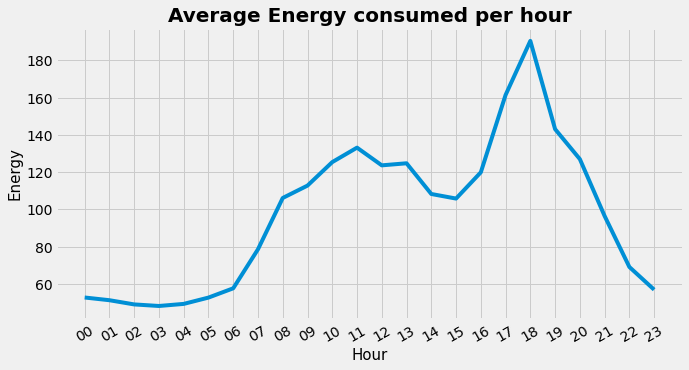

In [52]:
plt.figure(figsize=[10,5])
plt.style.use('fivethirtyeight')
plt.plot(hours['Appliances'].mean())
plt.title('Average Energy consumed per hour', fontsize = 20, weight = 'bold')
plt.xticks(rotation = '30')
plt.xlabel('Hour', fontsize = 15)
plt.ylabel('Energy', fontsize = 15);
plt.show()

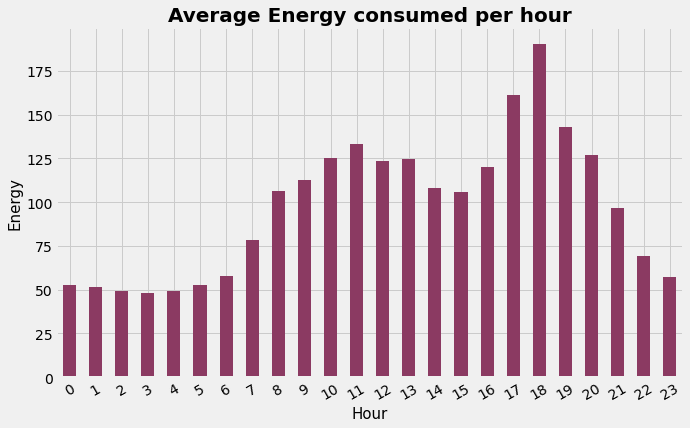

In [53]:
plt.rcParams['figure.figsize'] = [10, 6]

df.groupby('hour').agg({'Appliances' : 'mean'}).plot.bar(color = '#8B3A62', legend = False)
plt.title('Average Energy consumed per hour', fontsize = 20, weight = 'bold')
plt.xticks(rotation = '30')
plt.xlabel('Hour', fontsize = 15)
plt.ylabel('Energy', fontsize = 15);

- It seems that uses of Appliances rises during the day from 7 a.m to 10 p.m.
- Uses peaks at the evening.
- And it goes below 50 at night.


In [54]:
#Creating bins to divide daytime into different hour slots
hour_bins = [0, 6, 12, 16, 23, 24]
labels = ['Night', 'Morning', 'Afternoon', 'Evening', 'Night'] #Since 0 hrs and 24 hrs both represents midnight 
df['Session'] = pd.cut(df.hour,bins=hour_bins, right=False, labels=labels, ordered=False)

In [55]:
#Now we can drop the date column
df.drop('date',axis=1,inplace=True)

In [56]:
df.day_type.value_counts().to_frame(name = 'Count')

,Count
weekday,14263
weekend,5472


##Univariate analysis

In [57]:
df.Appliances.describe([.70,.80,.9,.99])

count    19735.000000
mean        97.694958
std        102.524891
min         10.000000
50%         60.000000
70%         90.000000
80%        110.000000
90%        196.000000
99%        576.600000
max       1080.000000
Name: Appliances, dtype: float64

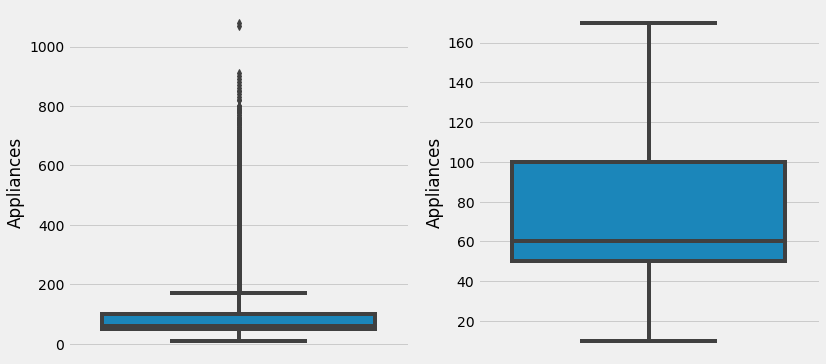

In [58]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12,6))
s1 = sns.boxplot(ax = ax1, y = 'Appliances', data = df, showfliers = True)
s2 = sns.boxplot(ax = ax2, y = 'Appliances', data = df, showfliers = False)
plt.show();

In [59]:
import plotly.express as px
px.histogram(df, x='Appliances', nbins = 50, color_discrete_sequence=['indianred'], text_auto = True)

Around 90% of Appliance consumption is less than 200 Wh. Whereas the maximum comsumption is of 1080 Wh which will be the outlier in the given column.

In [60]:
df.lights.unique()

array([30, 40, 50, 70, 60, 10, 20,  0])

Light column has only 8 unique values.

In [61]:
#Let us see the count of value in light column
df.lights.value_counts()

0     15252
10     2212
20     1624
30      559
40       77
50        9
70        1
60        1
Name: lights, dtype: int64

- Since most of the value in lights column is 0 thus we can drop this column.

In [62]:
#Dropping light column
df.drop('lights', axis=1, inplace =True)

### **Energy consumption**

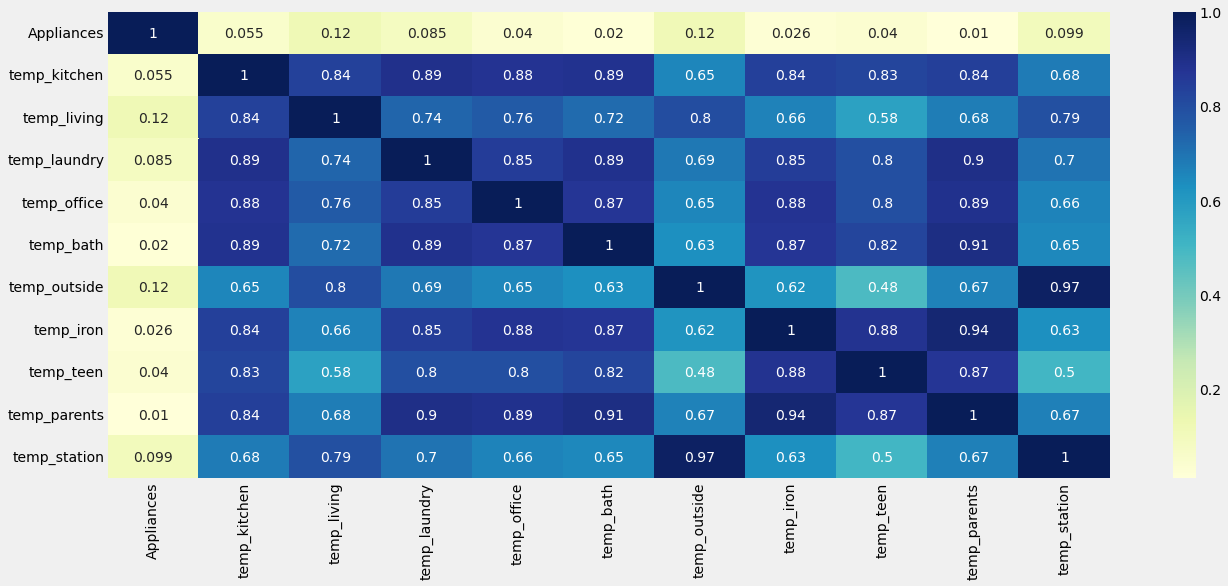

In [63]:
fig, ax = plt.subplots(1,1,figsize = (20, 8))
sns.heatmap(df[['Appliances', 'temp_kitchen', 'temp_living',
        'temp_laundry',  'temp_office',
        'temp_bath',  'temp_outside',
        'temp_iron',  'temp_teen', 
       'temp_parents',  'temp_station']].corr(), cmap='YlGnBu', ax=ax, annot=True);

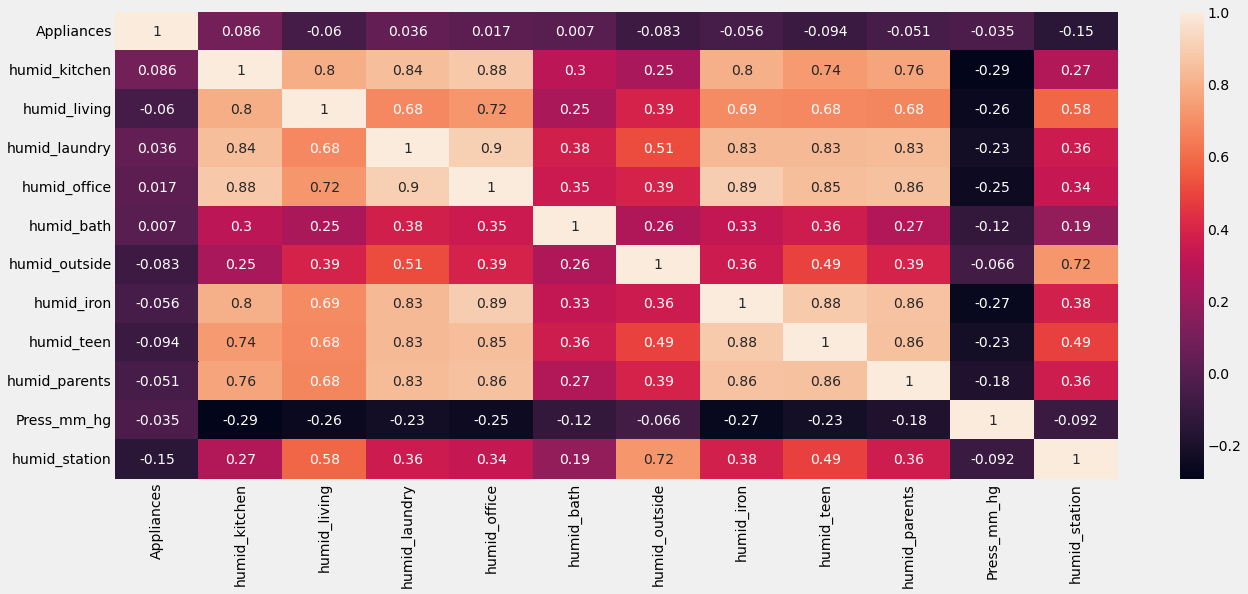

In [64]:
fig, ax = plt.subplots(1,1,figsize=(20,8))
sns.heatmap(df[['Appliances',  'humid_kitchen', 
       'humid_living',  'humid_laundry', 
       'humid_office',  'humid_bath', 
       'humid_outside',  'humid_iron',  'humid_teen',
        'humid_parents',  'Press_mm_hg',
       'humid_station',]].corr(), ax=ax, annot=True);

In [19]:
df.corr()

,Appliances,lights,temp_kitchen,humid_kitchen,temp_living,humid_living,temp_laundry,humid_laundry,temp_office,humid_office,...,temp_parents,humid_parents,temp_station,Press_mm_hg,humid_station,Windspeed,Visibility,Tdewpoint,rv1,rv2
Appliances,1.000000,0.197278,0.055447,0.086031,0.120073,-0.060465,0.085060,0.036292,0.040281,0.016965,...,0.010010,-0.051462,0.099155,-0.034885,-0.152282,0.087122,0.000230,0.015353,-0.011145,-0.011145
lights,0.197278,1.000000,-0.023528,0.106968,-0.005622,0.050985,-0.097393,0.131161,-0.008859,0.114936,...,-0.157592,-0.008766,-0.074424,-0.010576,0.068543,0.060281,0.020038,-0.036322,0.000521,0.000521
temp_kitchen,0.055447,-0.023528,1.000000,0.164006,0.836834,-0.002509,0.892402,-0.028550,0.877001,0.097861,...,0.844777,0.071756,0.682846,-0.150574,-0.345481,-0.087654,-0.076210,0.571309,-0.006203,-0.006203
humid_kitchen,0.086031,0.106968,0.164006,1.000000,0.269839,0.797535,0.253230,0.844677,0.106180,0.880359,...,0.115263,0.764001,0.340767,-0.293957,0.274126,0.204932,-0.021057,0.639106,-0.000699,-0.000699
temp_living,0.120073,-0.005622,0.836834,0.269839,1.000000,-0.165610,0.735245,0.121497,0.762066,0.231563,...,0.675535,0.157346,0.792255,-0.133028,-0.505291,0.052495,-0.069721,0.582602,-0.011087,-0.011087
humid_living,-0.060465,0.050985,-0.002509,0.797535,-0.165610,1.000000,0.137319,0.678326,-0.047304,0.721435,...,0.054544,0.676467,0.033674,-0.255646,0.584911,0.069190,-0.005368,0.499152,0.006275,0.006275
temp_laundry,0.085060,-0.097393,0.892402,0.253230,0.735245,0.137319,1.000000,-0.011234,0.852778,0.122737,...,0.901324,0.134602,0.699417,-0.189974,-0.281718,-0.100776,-0.102310,0.645886,-0.005194,-0.005194
humid_laundry,0.036292,0.131161,-0.028550,0.844677,0.121497,0.678326,-0.011234,1.000000,-0.140457,0.898978,...,-0.195270,0.833538,0.118207,-0.233274,0.356192,0.263188,0.017041,0.414387,-0.000477,-0.000477
temp_office,0.040281,-0.008859,0.877001,0.106180,0.762066,-0.047304,0.852778,-0.140457,1.000000,-0.048650,...,0.889439,-0.025549,0.663478,-0.075292,-0.388602,-0.185747,-0.104768,0.519471,-0.001815,-0.001815
humid_office,0.016965,0.114936,0.097861,0.880359,0.231563,0.721435,0.122737,0.898978,-0.048650,1.000000,...,-0.044518,0.856591,0.293289,-0.250748,0.336813,0.300192,0.002636,0.616509,-0.001787,-0.001787


**OBSERVATIONS :**

* **From the correlation graph we clearly observe that the features related to temperature and features related to humidity have positive correlation within themselves whereas have a a very low or negative correlation with each other.**
* **Humidity outside have a strong negative correlation with temperature levels as already discussed.**
* **Apart from that we observe that a couple features such as humidity at station, temperature outside the building and temperature in the living room have a comparatively high absolute correlation (above 0.12) with Appliances energy consumption.**

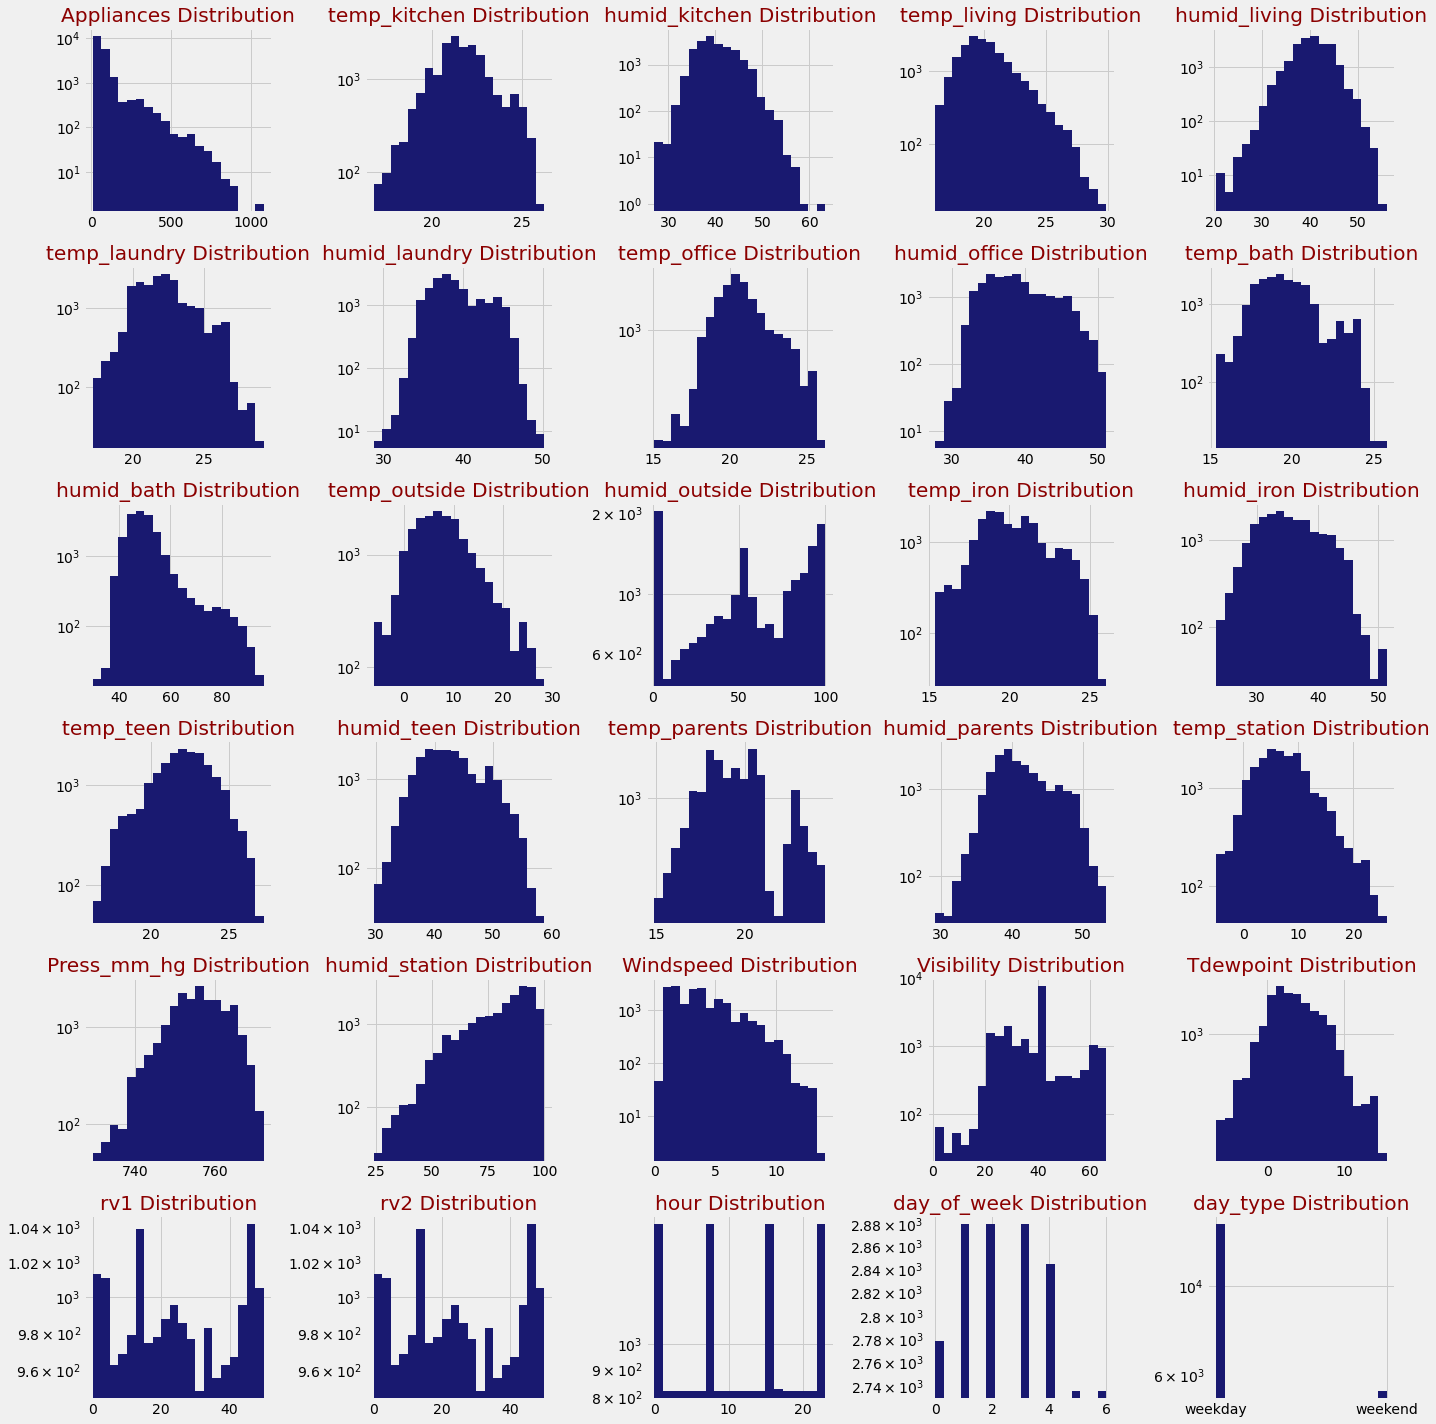

In [65]:
def draw_histograms(dataframe, features, rows, cols):
    fig = plt.figure(figsize = (20,20))
    for i, feature in enumerate(features):
        ax = fig.add_subplot(rows,cols,i+1)
        dataframe[feature].hist(bins = 20, ax = ax, facecolor = 'midnightblue')
        ax.set_title(feature+' Distribution', color = 'DarkRed')
        ax.set_yscale('log')
    fig.tight_layout()  
    plt.show()

draw_histograms(df,df.columns[:-1],6, 5)

* As we have observed earlier as well, there seenms to be no correlation between month and the observed energy use i.e. the enegy consumption pretty much remains similar over all months. Similarly there is no direct effect of weekdays on appliance energy consumption.**
* Although there is a correlation of 0.22 between hour and appliances**

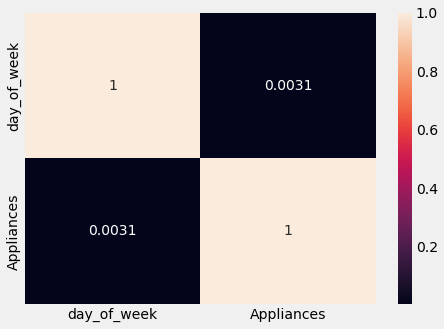

In [66]:
fig,ax = plt.subplots(1,1,figsize=(7,5))
sns.heatmap(df[['day_of_week', 'Appliances']].corr(), ax = ax, annot=True);

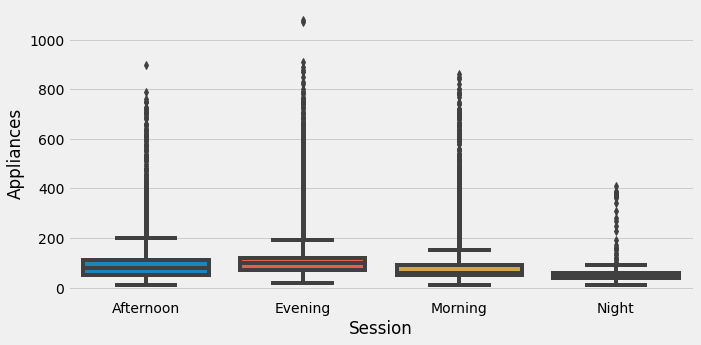

In [67]:
fig, ax = plt.subplots(1, 1,figsize = (10,5))
sns.boxplot(ax = ax, x = 'Session', y = 'Appliances', data = df, showfliers = True)
plt.show();

**Lets look at features related to weather as well.**

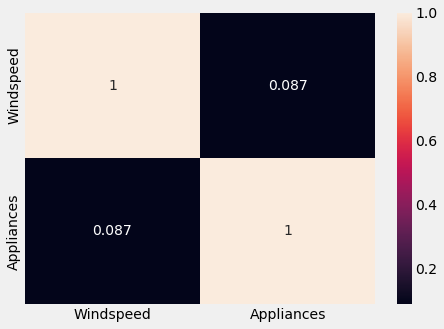

In [68]:
fig,ax = plt.subplots(1,1,figsize=(7,5))
sns.heatmap(df[['Windspeed', 'Appliances']].corr(), ax = ax, annot=True);

**Tdewpoint shows a high correlation with most of the tempearture and humidity level features than any other weather parameters. Pressure, windspeed and visibiltiy show little to know correlation. We might need to include these only these feaatures in our final model**

##Encoding the features

In [69]:
from sklearn.preprocessing import LabelEncoder

In [70]:
# Writing a function for label encoding for education column

def ordinal_encode(day_type):
    if day_type == 'weekend':
        return 1
    else:
        return 2
    
# Label encoding
df['day_type'] = df['day_type'].apply(ordinal_encode)

In [71]:
df.day_type.value_counts().to_frame(name = 'Count')

,Count
2,14263
1,5472


In [72]:
# Writing a function for label encoding for education column

def ordinal(Session):
    if Session == 'Evening':
        return 4
    elif Session == 'Night':
        return 1
    elif Session == 'Morning':
        return 2
    else:
        return 3
    
# Label encoding
df['Session'] = df['Session'].apply(ordinal)

In [73]:
df.Session.value_counts().to_frame(name = 'Count')

,Count
4,5761
1,5754
2,4932
3,3288


In [74]:
X_ind = df.drop('Appliances',axis=1)
Y_dep = df['Appliances']

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X_ind, Y_dep , test_size = 0.25, random_state = 0) 
print(X_train.shape)
print(X_test.shape)

(14801, 30)
(4934, 30)


In [76]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# PCA

In [ ]:
from sklearn.decomposition import PCA
pca = PCA()

In [ ]:
X_train_new = pca.fit_transform(X_train)
train_cov_matrix = np.cov(X_train_new.T)
eigen_vals_train, eigen_vecs_train = np.linalg.eig(train_cov_matrix)
explained_variance_train = pca.explained_variance_ratio_

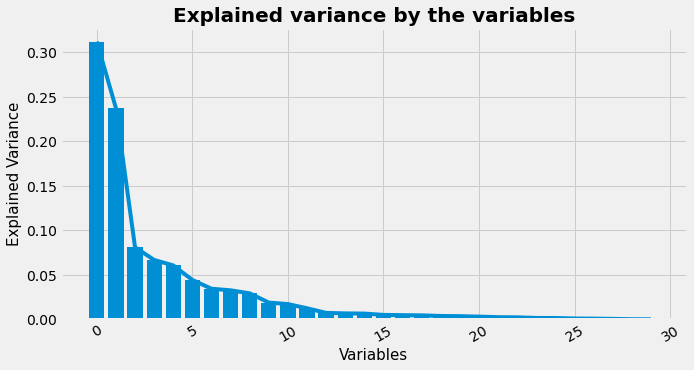

In [ ]:
plt.figure(figsize = (10,5))
plt.bar(range(30), explained_variance_train, label = 'Information gained by each PCA')
plt.plot(range(30), explained_variance_train)
plt.title('Explained variance by the variables', fontsize = 20, weight = 'bold')
plt.xticks(rotation = '30')
plt.xlabel('Variables', fontsize = 15)
plt.ylabel('Explained Variance', fontsize = 15);

In [ ]:
explained_variance_train

array([3.11895676e-01, 2.37148891e-01, 8.09206258e-02, 6.66298250e-02,
       6.05337243e-02, 4.41900547e-02, 3.43099649e-02, 3.25551994e-02,
       2.91388534e-02, 1.87682021e-02, 1.71231447e-02, 1.23802580e-02,
       7.20975708e-03, 6.63380382e-03, 6.41221554e-03, 4.95507074e-03,
       4.64836134e-03, 4.41782407e-03, 3.75771553e-03, 3.52405387e-03,
       3.01426357e-03, 2.38604422e-03, 2.21558131e-03, 1.50313666e-03,
       1.45600013e-03, 9.12441633e-04, 7.64508609e-04, 4.72895404e-04,
       1.21906886e-04, 2.33064931e-33])

In [ ]:
sum(explained_variance_train[0:13])

0.9528041766731582

95% variance explained by 13 PCA transformed features.

In [ ]:
pca = PCA(n_components = 13)
X_train = pca.fit_transform(X_train_new)

In [ ]:
X_test_new = pca.fit_transform(X_test)
test_cov_matrix = np.cov(X_test_new.T)
eigen_vals_test, eigen_vecs_test = np.linalg.eig(test_cov_matrix)
explained_variance_test = pca.explained_variance_ratio_

X_test = pca.fit_transform(X_test_new)

# Model Building

In [77]:
models = [
           ['Lasso: ', Lasso()],
           ['Ridge: ', Ridge()],
           ['SVR:' , SVR(kernel='rbf')],
           ['RandomForest ',RandomForestRegressor()],
           ['ExtraTreeRegressor :',ExtraTreesRegressor()],
           ['GradientBoostingRegressor: ', GradientBoostingRegressor()] ,
           ['XGBRegressor: ', xgb.XGBRegressor()]]

In [78]:
model_data = []
for name,curr_model in models :
    curr_model_data = {}
    curr_model.random_state = 78
    curr_model_data["Name"] = name
    start = time.time()
    curr_model.fit(X_train,y_train)
    end = time.time()
    curr_model_data["Train_Time"] = end - start
    curr_model_data["Train_R2_Score"] = r2_score(y_train,curr_model.predict(X_train))
    curr_model_data["Test_R2_Score"] = r2_score(y_test,curr_model.predict(X_test))
    curr_model_data["Test_RMSE_Score"] = np.sqrt(mean_squared_error(y_test,curr_model.predict(X_test)))
    model_data.append(curr_model_data)

[15:21:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [79]:
results_df = pd.DataFrame(model_data)

In [80]:
results_df

,Name,Train_Time,Train_R2_Score,Test_R2_Score,Test_RMSE_Score
0,Lasso:,0.037745,0.149500,0.126500,99.233723
1,Ridge:,0.024162,0.168586,0.145895,98.125837
2,SVR:,19.904667,0.030840,0.012656,105.502338
3,RandomForest,35.703855,0.938648,0.534987,72.403646
4,ExtraTreeRegressor :,10.036509,1.000000,0.582087,68.638994
5,GradientBoostingRegressor:,9.644902,0.368383,0.268605,90.803785
6,XGBRegressor:,2.122677,0.355851,0.263048,91.148038


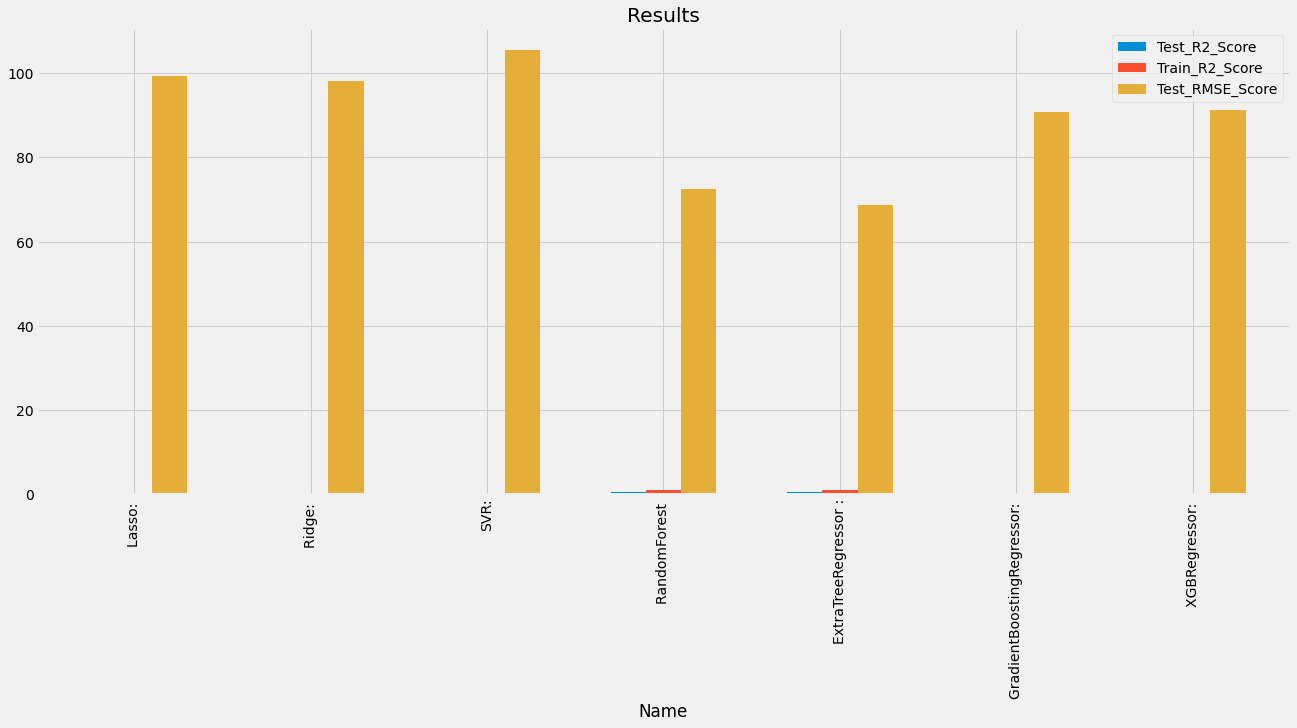

In [81]:
results_df.plot.bar(x="Name", y=['Test_R2_Score' , 'Train_R2_Score' , 'Test_RMSE_Score'], title = 'Results' , width = .6, figsize= (20,8));

In [82]:
from sklearn.model_selection import RandomizedSearchCV
param_random = [{
              'max_depth': [80, 150, 200,250],
              'n_estimators' : [100,150,200,250],
              'max_features': ["auto", "sqrt", "log2"]
            }]
reg = ExtraTreesRegressor(random_state=40)
random_search = RandomizedSearchCV(estimator = reg, param_distributions = param_random, cv = 5, n_jobs = -1 , scoring='r2' , n_iter = 5, verbose=2)
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5, estimator=ExtraTreesRegressor(random_state=40),
                   n_iter=5, n_jobs=-1,
                   param_distributions=[{'max_depth': [80, 150, 200, 250],
                                         'max_features': ['auto', 'sqrt',
                                                          'log2'],
                                         'n_estimators': [100, 150, 200, 250]}],
                   scoring='r2', verbose=2)

In [83]:
random_search.best_params_

{'max_depth': 150, 'max_features': 'log2', 'n_estimators': 200}

In [84]:
random_search.best_estimator_

ExtraTreesRegressor(max_depth=150, max_features='log2', n_estimators=200,
                    random_state=40)

In [85]:
random_search.best_estimator_.score(X_train,y_train)

0.9999986688915254

In [86]:
random_search.best_estimator_.score(X_test,y_test)

0.5932741901952097

In [87]:
np.sqrt(mean_squared_error(y_train, random_search.best_estimator_.predict(X_train)))

0.11683772061777462

In [88]:
np.sqrt(mean_squared_error(y_test, random_search.best_estimator_.predict(X_test)))

67.71403252033397